In [204]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

## Business Context

You are hired as an AIoT engineer to develop a system 
1. That predicts the upcoming month's electricity bill and 
2. Identifies the electronic devices contributing the most to the cost. 

The system utilizes real-time sensor data collected from various household appliances.

## Read Files
The data gathered by the ESP32 microcontroller and already exported into a CSV File. The data has these columns:
1. Timestamp
2. Device ID (identifies specific appliance - TV, AC, Lamp, PC, Refrigerator)
3. Voltage (V)
4. Ampere (A)

In [205]:
df_raw = pd.read_csv('dataset/electricity_consumption.csv')
df = df_raw.copy()
df.head(5)

,Timestamp,Device ID,Ampere (A),Voltage (V)
0,2020-01-01 00:00:00,Refrigerator,1.449294,222.867083
1,2020-01-01 00:00:00,AC,1.693157,238.016858
2,2020-01-01 00:00:00,Lamp,0.982116,204.660203
3,2020-01-01 01:00:00,Refrigerator,1.539718,215.623843
4,2020-01-01 01:00:00,AC,1.486501,228.052272


## Exploratory Data Analysis (EDA)
It is a common practice to have a sense about how our data is.

### Checking Datatypes

In [206]:
df.dtypes

Timestamp       object
Device ID       object
Ampere (A)     float64
Voltage (V)    float64
dtype: object

### Adjusting Datatypes

In [207]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

### Checking Data Stats

In [208]:
df.describe()

,Timestamp,Ampere (A),Voltage (V)
count,127110,127110.000000,127110.000000
mean,2021-12-31 12:31:02.025017600,1.226298,220.023427
min,2020-01-01 00:00:00,0.047394,200.000237
25%,2020-12-31 07:00:00,0.518434,209.995898
50%,2021-12-31 12:30:00,1.319635,220.831590
75%,2022-12-31 18:00:00,1.539657,229.824356
max,2024-01-01 00:00:00,4.536216,240.999390
std,NaN,0.794598,11.074154


In [209]:
df['Device ID'].unique()

array(['Refrigerator', 'AC', 'Lamp', 'TV', 'PC'], dtype=object)

### Checking Nulls

In [210]:
df.isnull().sum()

Timestamp      0
Device ID      0
Ampere (A)     0
Voltage (V)    0
dtype: int64

### Renaming Columns

In [211]:
df.rename(columns={'Voltage (V)': 'V',
                   'Ampere (A)': 'A',
                   'Device ID': 'Device'}, inplace=True)

### Adding Necessary Feature
It seems like we have 2 components in our dataset, Voltage (V) & Ampere (A). As our goal is to measure upcoming's electricity bills, we need to find the power consumed, which is Watt (W). We can simply calculate it by multiplying the Voltage (V) & Ampere (A).

In [212]:
df['W'] = df['V'] * df['A']

### Data Visualization

#### Checking Data Distribution of each features

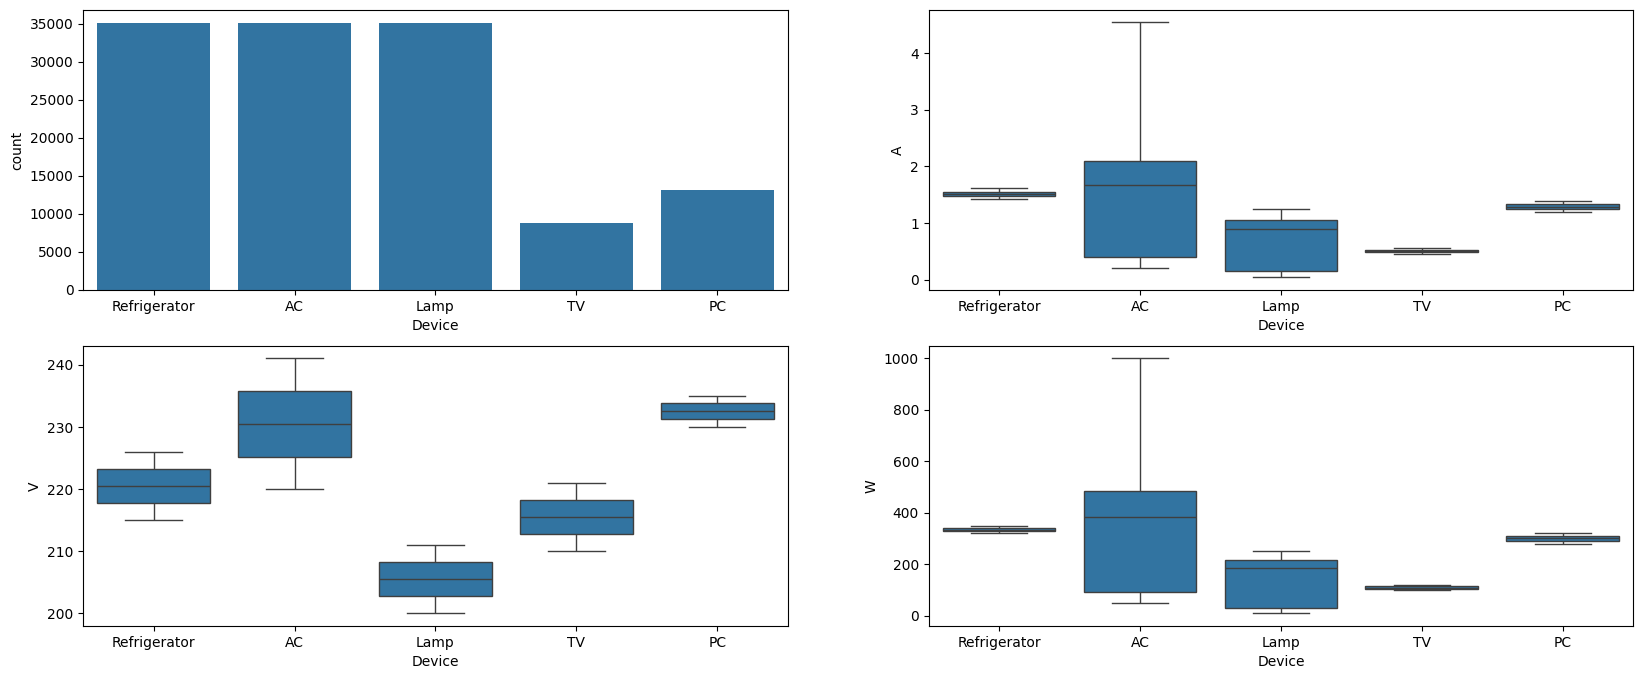

In [213]:
fig, axs = plt.subplots(2, 2, figsize=(20, 8))

sns.countplot(data=df, x='Device', ax=axs[0][0])
sns.boxplot(data=df, x='Device', y='A', ax=axs[0][1])
sns.boxplot(data=df, x='Device', y='V', ax=axs[1][0])
sns.boxplot(data=df, x='Device', y='W', ax=axs[1][1])

plt.show()


#### Checking Trends
- From these visualizations, it appears that there's seasonality in our dataset
- Most of the devices tend to have stable electricity consumption, except AC
- We see that there's repeating pattern in AC consumption
- It appears that more electricity is consumed during April - October in each year

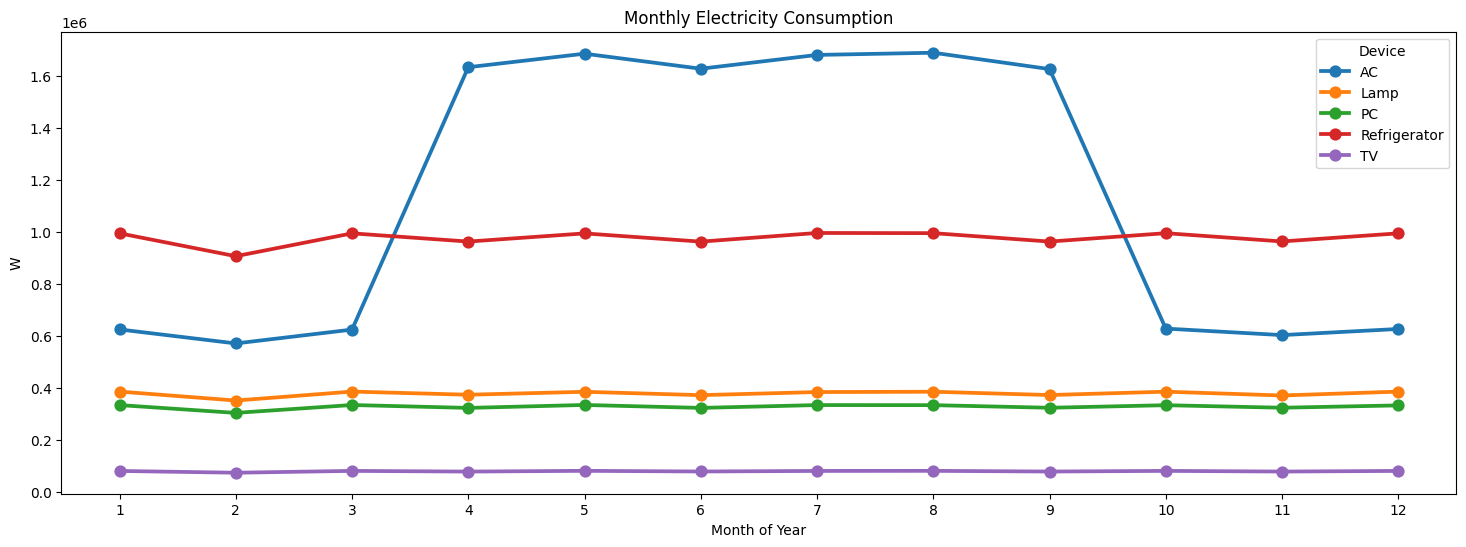

In [215]:
fig, axs = plt.subplots(1, 1, figsize=(18, 6))

# data = df_daily_consumtion[df_daily_consumtion['Timestamp'].dt.year == 2020]
data = df_daily_consumtion.groupby(['Device', df_daily_consumtion['Timestamp'].dt.month]).sum('W').reset_index()

sns.pointplot(data=data, hue='Device', x='Timestamp', y='W', ax=axs)
axs.set_xlabel('Month of Year')
axs.set_title('Monthly Electricity Consumption')
plt.show()

#### Checking Hourly Trends
It seems that some devices is only active during some periods of time.
- AC & Lamps tends to consumed higher during the night
- PC only consumes energy during working hours (10.00 - 17.00)
- Refrigerator is on all day
- TV only on around lunch time and late night 
- It appears that electricity consumption is higher during the night, peaking at 21.00 - 23.00 and lowest at 07.00 - 09.00


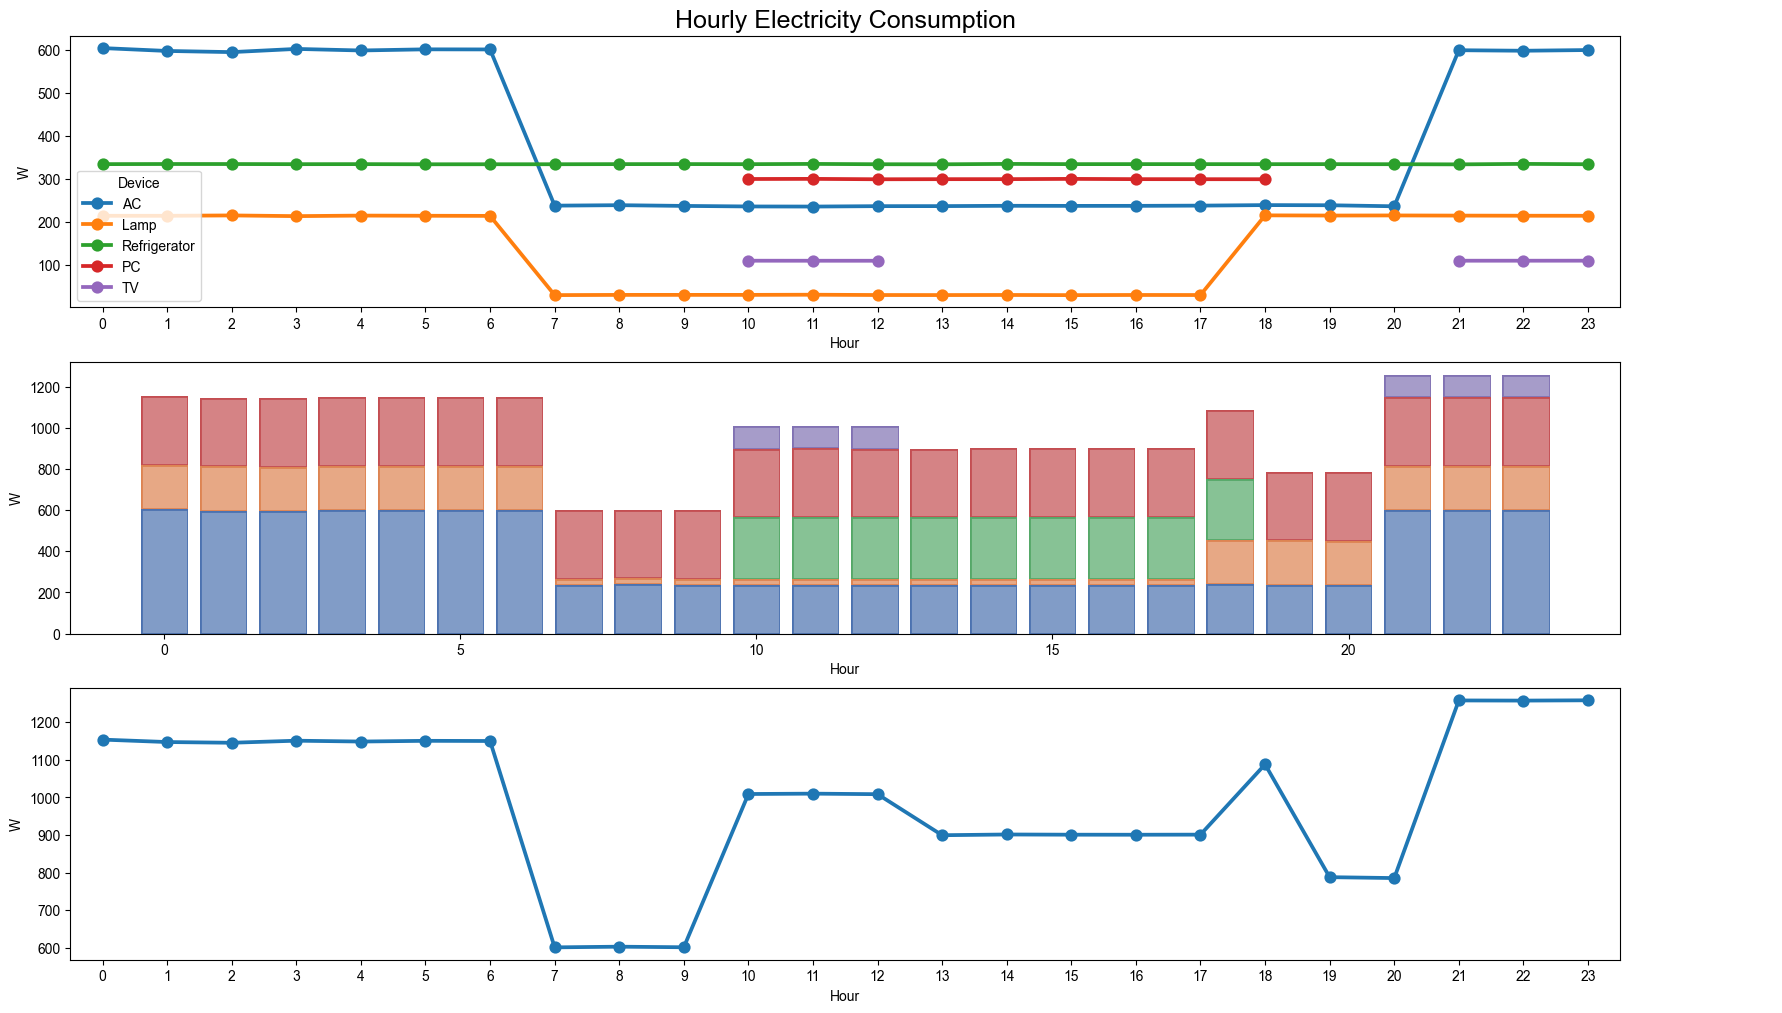

In [216]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12))

axs[0].set_title('Hourly Electricity Consumption', fontdict={'fontsize': 18, 'fontweight': 'medium'})

df_hourly_consumption = df.groupby(['Device', df['Timestamp'].dt.hour]).agg({'W': 'mean'})
df_hourly_consumption.reset_index(inplace=True)
df_hourly_consumption.rename(columns={'Timestamp': 'Hour'}, inplace=True)

# Line plot
sns.pointplot(data=df_hourly_consumption, hue='Device', x='Hour', y='W', ax=axs[0])

# Plot hourly trend all devices
data = df_hourly_consumption.groupby('Hour').sum('W').reset_index()
sns.pointplot(data=data, x='Hour', y='W', ax=axs[2])

# Stacked bar chart
so.Plot(df_hourly_consumption, x='Hour', y='W', color='Device').add(so.Bar(), so.Stack()).on(axs[1]).show()




## Modelling

### Feature Engineering

First we group the data by each timestamp with 1 hour frequency 

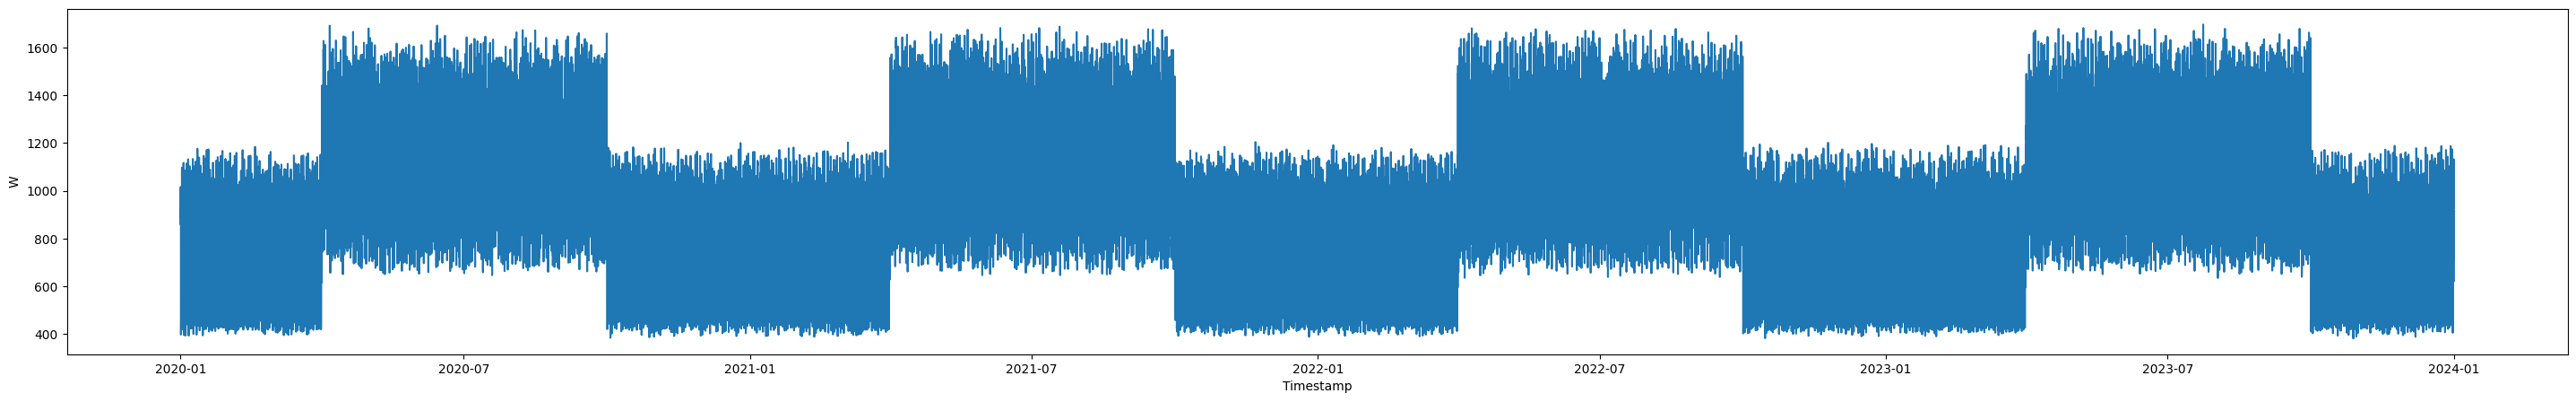

In [217]:
fig, axs = plt.subplots(1, 1, figsize=(36, 5))

df_grouped = df.groupby(pd.Grouper(key='Timestamp', freq='1h')).agg({'W': 'sum'})

sns.lineplot(data=df_grouped, x='Timestamp', y='W', ax=axs)

plt.show()

Then we extract time features from timestamp as we see time features affects electricity consumption, we split in into:
1. Hour
2. Day of Week
3. Quarter
4. Month
5. Year
6. Day of Year

In [218]:
def createTimeFeatures(df):
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["day_of_year"] = df.index.dayofyear


# apply the method to the existing dataframe
createTimeFeatures(df_grouped)

df_grouped.head()

,W,hour,day_of_week,quarter,month,year,day_of_year
Timestamp,,,,,,,
2020-01-01 00:00:00,927.0,0,2,1,1,2020,1
2020-01-01 01:00:00,888.0,1,2,1,1,2020,1
2020-01-01 02:00:00,944.0,2,2,1,1,2020,1
2020-01-01 03:00:00,1016.0,3,2,1,1,2020,1
2020-01-01 04:00:00,888.0,4,2,1,1,2020,1


### Train Test Split
We split the data into 75:25 train:test ratio with cut off date around 2023-01-01

cutOffDate 2023-01-01 00:00:00
Train Size: 26305 (75.02%)
Test Size: 8760 (24.98%)


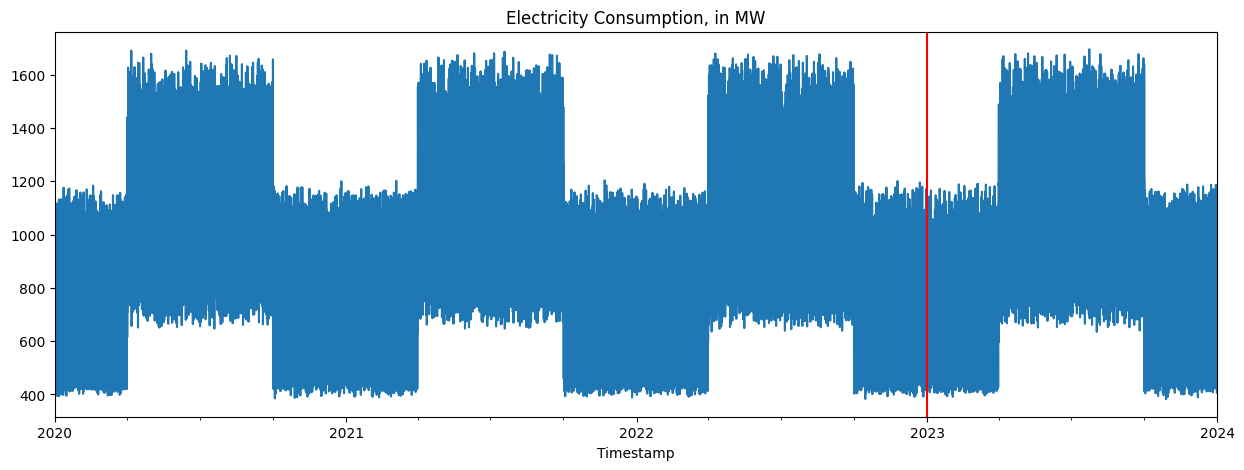

In [219]:
cutOffDate = '2023-01-01 00:00:00'
print(f"cutOffDate {cutOffDate}")

train = df_grouped.loc[df_grouped.index <= cutOffDate]
test = df_grouped.loc[df_grouped.index > cutOffDate]

print(f"Train Size: {len(train)} ({len(train)*100/len(df_grouped):.2f}%)")
print(f"Test Size: {len(test)} ({len(test)*100/len(df_grouped):.2f}%)")

df_grouped["W"].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
# plt.ylabel('MW')
plt.axvline(x=cutOffDate, color='r')
plt.show()

### Training...
We choose XGBoost Regressor for our case. We try different hyperparameter setups:
1. XGBRegressor(n_estimators=100)
1. XGBRegressor(n_estimators=200)
1. XGBRegressor(n_estimators=500)
1. XGBRegressor(n_estimators=1000)

In [220]:
def meanAbsolutErrorAaPercentage(real, predicted):
    real = np.array(real)
    predicted = np.array(predicted)

    return np.mean(np.abs((real - predicted) / real)) * 100

In [232]:
%%time

from sklearn.metrics import mean_absolute_error

# define our features and our target as separate arrays
FEATURES = ["hour", "day_of_week", "quarter", "month", "year", "day_of_year"]
TARGET = "W"
# define a list of n_estimators values to experiment with
n_estimators_values = [100, 200, 500, 1000]

# initialize variables to track the best model and its error
best_model = None
best_error = float('inf')  # initialize with a large value

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# loop through the different n_estimators values
for n_estimators in n_estimators_values:

    # define and XGB regressor, fit it on our train data and use it to predict our test data
    regressor = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=0.01)

    regressor.fit(X_train, y_train)
    # regressor.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
    regressorOutput = regressor.predict(X_test)

    # calculate the mean squared error
    error = mean_absolute_error(y_test, regressorOutput)
    
    # print the error for this model
    print(f"n_estimators={n_estimators}, Mean Squared Error: {error}")
    
    # update the best model if the current model has a lower error
    if error < best_error:
        best_prediction = regressorOutput
        best_error = error
        best_model = regressor

# print the best model's parameters and error
print(f"Best Model: {best_model}")
print(f"Best Mean Squared Error: {best_error}")


n_estimators=100, Mean Squared Error: 99.69053100167889
n_estimators=200, Mean Squared Error: 65.77540834331077
n_estimators=500, Mean Squared Error: 52.97931206759797
n_estimators=1000, Mean Squared Error: 56.3602841799662
Best Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Best Mean Squared 

### Predicts...
After getting the best hyperparameter setups, we test it on test set

In [233]:
prediction = pd.DataFrame(data=best_prediction, index=X_test.index, columns=["prediction"])
df_grouped['prediction'] = prediction

# our predictions are at the end of the dataframe, so we should print that
df_grouped.tail()

,W,hour,day_of_week,quarter,month,year,day_of_year,prediction
Timestamp,,,,,,,,
2023-12-31 20:00:00,620.0,20,6,4,12,2023,365,634.530579
2023-12-31 21:00:00,1061.0,21,6,4,12,2023,365,1079.532593
2023-12-31 22:00:00,1132.0,22,6,4,12,2023,365,1075.715332
2023-12-31 23:00:00,1127.0,23,6,4,12,2023,365,1094.477173
2024-01-01 00:00:00,927.0,0,0,1,1,2024,1,955.283325


In [231]:
# select the part of the data frame that is our test part
testDf = df_grouped.loc[df_grouped.index > cutOffDate]

yReal = testDf["W"]
yPredicted = testDf["prediction"]

print(f"Percentage Error: {meanAbsolutErrorAaPercentage(yReal, yPredicted):.2f}%")

Percentage Error: 5.08%


### Prediction Visualization
With the 5.08% error, we visualize our prediction on to the true label  

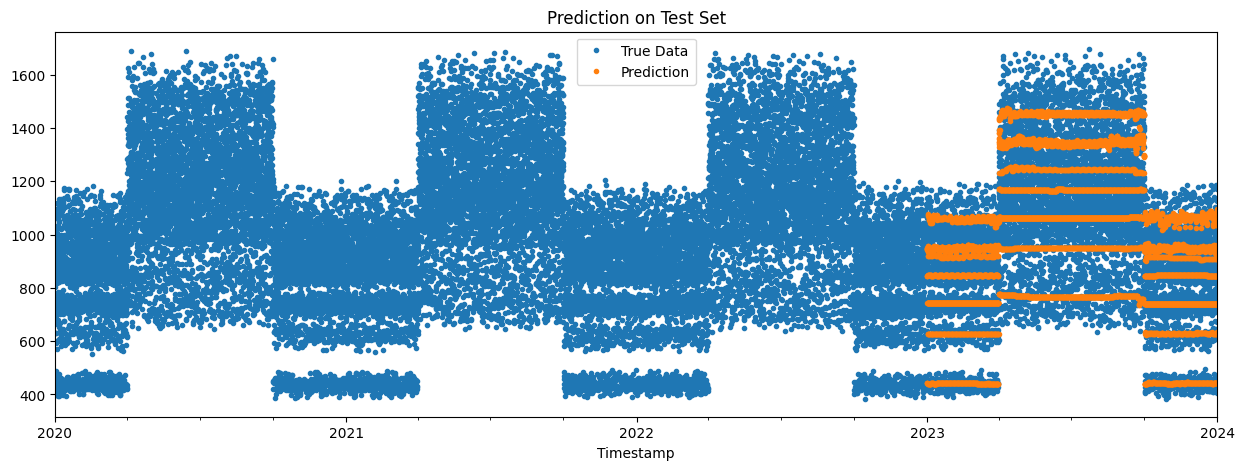

In [234]:
ax = df_grouped[[TARGET]].plot(figsize=(15,5), style='.')
df_grouped["prediction"].plot(ax=ax, style=".")
ax.legend(["True Data", "Prediction"])
ax.set_title("Prediction on Test Set")
plt.show()

### Dump Model

In [ ]:
import pickle
file_name = "model/xgb_reg.pkl"

# save
pickle.dump(best_model, open(file_name, "wb"))